In [3]:
import pandas as pd
import numpy as np
from patsy import dmatrices
from sklearn import tree, metrics
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, f1_score, precision_score, recall_score
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [266]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import seaborn as sns

colors = ['#F6BEC7','#836EA9']
custom_cmap = ListedColormap(colors)
n_bins = 20  # Number of color bins for the gradient
cmap_name = 'my_custom_colormap'

gradient_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)


def plot_confusion_matrix(y_real, y_pred):
    cm = confusion_matrix(y_real, y_pred)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g',cmap = gradient_cmap)

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

In [267]:
df= pd.read_csv('final_train_data.csv')
df.drop(columns=['ID'],axis=1,inplace=True)
df.head()

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response,Region,Policy_Channel
0,1,44,1,0,2,1,40454,217,1,West,Online Marketplace
1,1,47,1,0,2,1,38294,27,1,West,Online Marketplace
2,0,56,1,0,1,1,32031,72,1,West,Online Marketplace
3,1,79,1,0,1,1,57444,222,0,West,Online Marketplace
4,1,39,1,0,1,1,57582,141,0,West,Online Marketplace


In [268]:
formula = 'Response ~ ' + ' + '.join(['Q("'+x+'")' \
                                    for x in df.columns.values\
                                    if x != 'Response'])

In [269]:
Y, X = dmatrices(formula, df, return_type='dataframe')
y = Y['Response'].values

In [270]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=1)

In [271]:
# from sklearn.model_selection import cross_val_score, StratifiedKFold

# # Create the folds in the training data
# kfold = StratifiedKFold(n_splits=3, shuffle=True)

# # Iterate over max_depth
# for max_depth in [1, 2, 3, 4, 5,6,7,8,9,10,15]:
#     model3 = tree.DecisionTreeClassifier(criterion='gini', max_depth=max_depth)
#     scores = cross_val_score(model3, X_train, y_train, cv=kfold)
#     print('max_depth={} scores={} avg_score={}'.format(max_depth, scores, scores.mean()))

Random Forest

In [272]:
#Random forest fitting

rf=RandomForestClassifier(n_estimators=200, max_features=5, random_state=1)
rf.fit(X_train, y_train)
rf.feature_importances_

array([0.        , 0.00556559, 0.00348653, 0.00527892, 0.00671725,
       0.00279132, 0.00247748, 0.01251411, 0.0052727 , 0.00232646,
       0.0033265 , 0.00235232, 0.00599752, 0.01286198, 0.16677824,
       0.00058021, 0.04716194, 0.01854283, 0.07595248, 0.28622696,
       0.33378866])

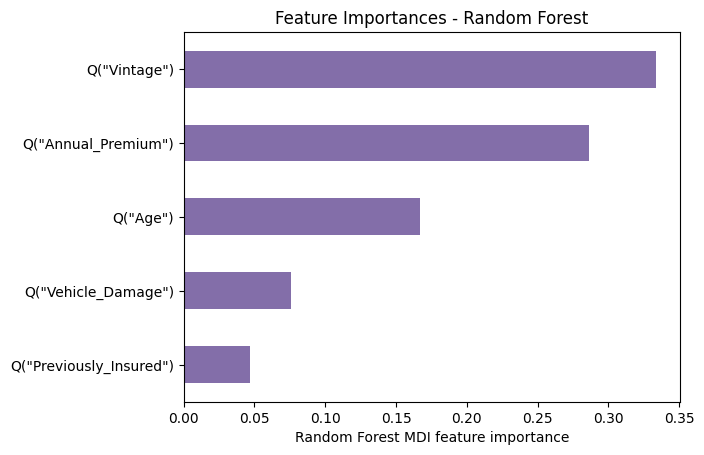

In [273]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5)[::-1].plot(kind='barh', color='#836EA9')
title("Feature Importances - Random Forest")
xlabel("Random Forest MDI feature importance")
show()

Accuracy score is: 0.8622532427208243
Recall is: 0.15137844611528822
Precision is: 0.35163007318695944
F1 is: 0.21164338989838313


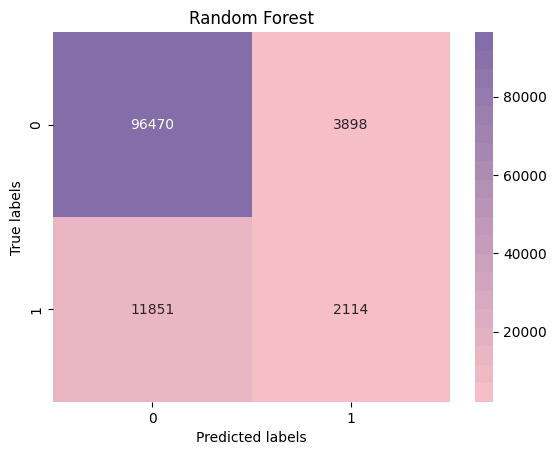

In [274]:
#Random forest prediction and metrics

rf_pred = rf.predict(X_test)
print("Accuracy score is:", accuracy_score(y_test,rf_pred))
print("Recall is:", recall_score(y_test,rf_pred))
print("Precision is:", precision_score(y_test,rf_pred))
print("F1 is:", f1_score(y_test,rf_pred))
plot_confusion_matrix(y_test,rf_pred)

title('Random Forest')
show()

While the accuracy is pretty good, according to our business problem statement, we need to minimize False negatives (We do not want to predict a 0 when a customer is interested)

Hence we need to increase our Recall while having a tradeoff in overall accuracy

We need to adjust TPR while maintaining a minimum overall accuracy

In [275]:
#Setting thresholds acc to higher TPR
predictions_rf= rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, predictions_rf)

# Find index of threshold that gives desired TPR
desired_tpr = 0.75  # Adjust to your desired TPR (minimize false negatives)
threshold_index = np.argmax(tpr >= desired_tpr)

# Select threshold that achieves desired FPR with acceptable TPR
selected_threshold = thresholds[threshold_index]
selected_fpr = fpr[threshold_index]
selected_tpr = tpr[threshold_index]

# Print results
print("Selected Threshold:", selected_threshold)
print("Selected FPR:", selected_fpr)
print("Selected TPR:", selected_tpr)

rf_pred = np.where(predictions_rf >= selected_threshold, 1, 0)

Selected Threshold: 0.155
Selected FPR: 0.2540650406504065
Selected TPR: 0.751593268886502


Accuracy score is: 0.7466260834579692
Recall is: 0.751593268886502
Precision is: 0.29158795421713524


F1 is: 0.42016773083004744


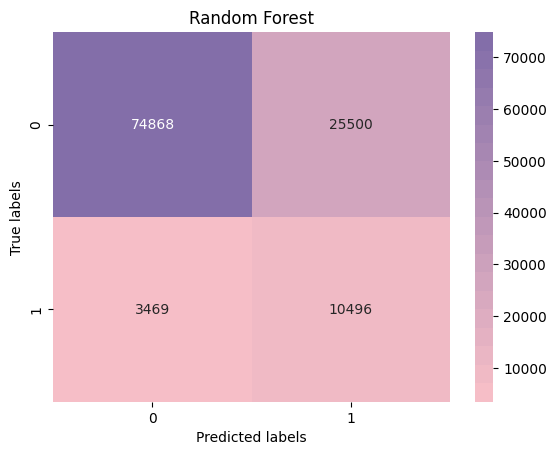

In [276]:
print("Accuracy score is:", accuracy_score(y_test,rf_pred))
print("Recall is:", recall_score(y_test,rf_pred))
print("Precision is:", precision_score(y_test,rf_pred))
print("F1 is:", f1_score(y_test,rf_pred))

plot_confusion_matrix(y_test,rf_pred)
title('Random Forest')
show()
# con= confusion_matrix(y_test,rf_pred, labels=rf.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=con,
#                             display_labels=rf.classes_)
# print('The confusion matrix for {} model is:\n'.format('Random Forest'))
# disp.plot(values_format="d")
# title('Random Forest')
# show()

Gradient Boosting

In [277]:
boosting = GradientBoostingClassifier(n_estimators=400,
                               max_depth=3,
                               random_state=1)
boosting.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=400, random_state=1)

Text(0.5, 0, 'Gradient Boosting MDI feature importance')

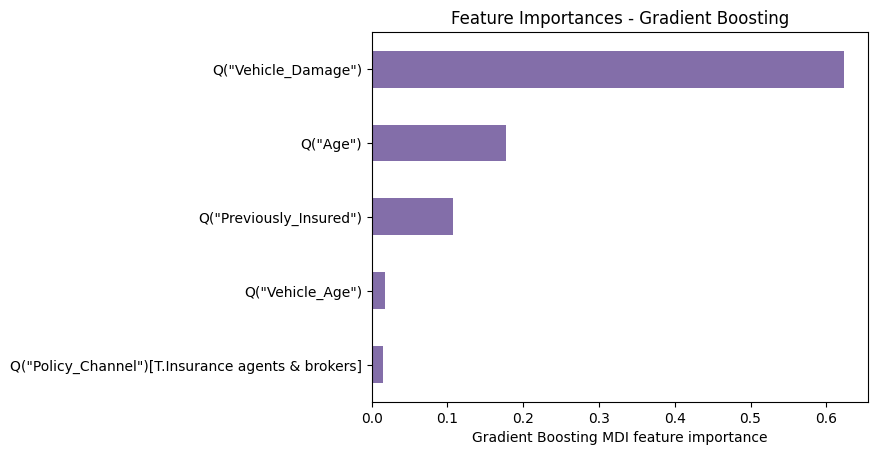

In [278]:
feat_importances = pd.Series(boosting.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5)[::-1].plot(kind='barh', color='#836EA9')
title("Feature Importances - Gradient Boosting")
xlabel("Gradient Boosting MDI feature importance")

Accuracy score is: 0.8777430837990782
Recall is: 0.007017543859649123
Precision is: 0.4688995215311005
F1 is: 0.013828136023705376


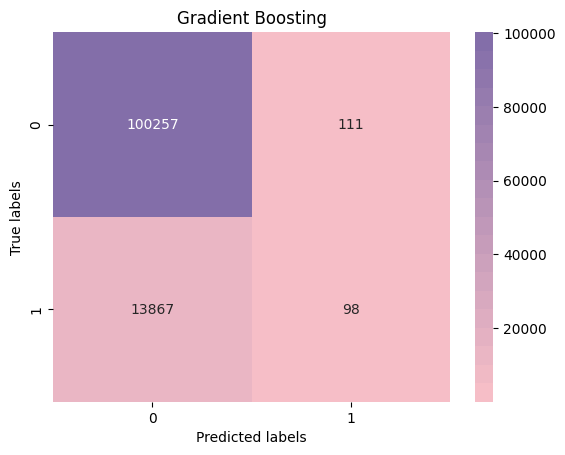

In [279]:
#Boosting prediction and metrics

boosting_pred = boosting.predict(X_test)
print("Accuracy score is:", accuracy_score(y_test,boosting_pred))
print("Recall is:", recall_score(y_test,boosting_pred))
print("Precision is:", precision_score(y_test,boosting_pred))
print("F1 is:", f1_score(y_test,boosting_pred))
plot_confusion_matrix(y_test,boosting_pred)
title('Gradient Boosting')
show()

In [280]:
#Setting thresholds acc to higher TPR
predictions_boosting= boosting.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, predictions_boosting)

# Find index of threshold that gives desired TPR
desired_tpr = 0.75  # Adjust to your desired TPR (minimize false negatives)
threshold_index = np.argmax(tpr >= desired_tpr)

# Select threshold that achieves desired FPR with acceptable TPR
selected_threshold = thresholds[threshold_index]
selected_fpr = fpr[threshold_index]
selected_tpr = tpr[threshold_index]

# Print results
print("Selected Threshold:", selected_threshold)
print("Selected FPR:", selected_fpr)
print("Selected TPR:", selected_tpr)

boosting_pred = np.where(predictions_boosting >= selected_threshold, 1, 0)

Selected Threshold: 0.23012370740129312
Selected FPR: 0.2152478877729954
Selected TPR: 0.7500179018976011


Accuracy score is: 0.7805095641678256
Recall is: 0.7500179018976011
Precision is: 0.32651661574911156
F1 is: 0.45496601003409853


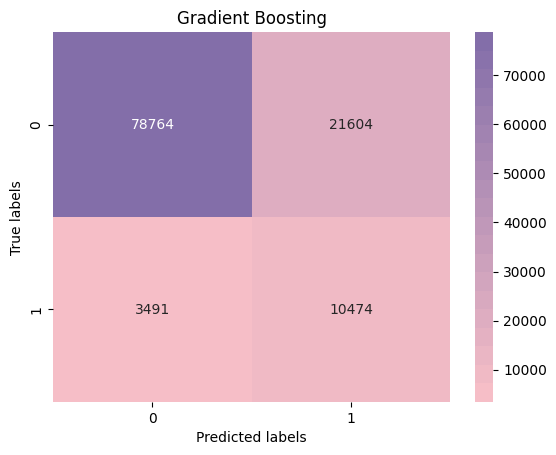

In [281]:
print("Accuracy score is:", accuracy_score(y_test,boosting_pred))
print("Recall is:", recall_score(y_test,boosting_pred))
print("Precision is:", precision_score(y_test,boosting_pred))
print("F1 is:", f1_score(y_test,boosting_pred))

plot_confusion_matrix(y_test,boosting_pred)
title('Gradient Boosting')
show()

Extreme Gradient Boosting

In [282]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

xgb=XGBClassifier(max_depth=3, n_estimators=400,
                               random_state=1)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [283]:
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]
y_pred = xgb.predict(X_test)
accuracy_score(y_test, y_pred)

0.8773494966457628

Naive Bayes

In [4]:
df= pd.read_csv('final_train_data.csv')
df.drop(columns=['ID'],axis=1,inplace=True)
df.head()

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response,Region,Policy_Channel
0,1,44,1,0,2,1,40454,217,1,West,Online Marketplace
1,1,47,1,0,2,1,38294,27,1,West,Online Marketplace
2,0,56,1,0,1,1,32031,72,1,West,Online Marketplace
3,1,79,1,0,1,1,57444,222,0,West,Online Marketplace
4,1,39,1,0,1,1,57582,141,0,West,Online Marketplace


In [5]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df,
                                                    test_size=0.3,
                                                    random_state=1)

In [6]:
df= train_df

In [7]:
df

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response,Region,Policy_Channel
221316,1,30,1,1,0,0,24616,132,0,Central,Insurance agents & brokers
31725,1,46,1,0,1,1,39709,258,0,West,Online Marketplace
336037,1,21,1,0,0,1,42878,18,0,West,Bancassurance(Bank partnerships)
52068,1,62,1,0,1,1,55064,248,0,Central,Online Marketplace
160070,0,25,1,1,0,0,22621,50,0,West,Insurance agents & brokers
...,...,...,...,...,...,...,...,...,...,...,...
73349,0,45,1,0,1,1,2630,124,0,North,Online Marketplace
371403,0,75,1,0,1,1,56985,101,1,West,Others
312201,1,46,1,0,1,1,52694,48,0,East,Point of Sales
267336,1,23,1,0,0,1,2630,245,0,East,Insurance agents & brokers


In [8]:
df['Age Binned'], age_bins= pd.qcut(df['Age'],7,retbins=True)
df['Age Binned'].unique()

[(25.0, 31.0], (41.0, 47.0], (19.999, 23.0], (57.0, 85.0], (23.0, 25.0], (31.0, 41.0], (47.0, 57.0]]
Categories (7, interval[float64, right]): [(19.999, 23.0] < (23.0, 25.0] < (25.0, 31.0] < (31.0, 41.0] < (41.0, 47.0] < (47.0, 57.0] < (57.0, 85.0]]

In [9]:
df['Vehicle Age Binned'], veh_age_bins= pd.qcut(df['Vehicle_Age'],2,retbins=True)
df['Vehicle Age Binned'].unique()

[(-0.001, 1.0], (1.0, 2.0]]
Categories (2, interval[float64, right]): [(-0.001, 1.0] < (1.0, 2.0]]

In [10]:
df['Annual_Premium Binned'], prem_bins= pd.qcut(df['Annual_Premium'],5,retbins=True)
df['Annual_Premium Binned'].unique()

[(21615.0, 29092.0], (34426.0, 41724.0], (41724.0, 540165.0], (2629.999, 21615.0], (29092.0, 34426.0]]
Categories (5, interval[float64, right]): [(2629.999, 21615.0] < (21615.0, 29092.0] < (29092.0, 34426.0] < (34426.0, 41724.0] < (41724.0, 540165.0]]

In [11]:
df['Vintage Binned'], vintage_bins= pd.qcut(df['Vintage'], 7,retbins=True )
df['Vintage Binned'].unique()

[(92.0, 133.0], (217.0, 258.0], (9.999, 51.0], (133.0, 175.0], (258.0, 299.0], (51.0, 92.0], (175.0, 217.0]]
Categories (7, interval[float64, right]): [(9.999, 51.0] < (51.0, 92.0] < (92.0, 133.0] < (133.0, 175.0] < (175.0, 217.0] < (217.0, 258.0] < (258.0, 299.0]]

In [12]:
categorical_columns= ['Gender', 'Driving_License', 'Previously_Insured',
            'Vehicle_Damage',
     'Region', 'Policy_Channel', 'Age Binned',
       'Vehicle Age Binned', 'Annual_Premium Binned', 'Vintage Binned']

In [13]:
df_dummies = pd.get_dummies(df[categorical_columns],
                            prefix=categorical_columns,
                            columns=categorical_columns)
dummy_column_names = df_dummies.columns.values
len(dummy_column_names)

43

In [14]:
df2= pd.concat([df,df_dummies], axis=1)

In [15]:
df2

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response,Region,...,"Annual_Premium Binned_(29092.0, 34426.0]","Annual_Premium Binned_(34426.0, 41724.0]","Annual_Premium Binned_(41724.0, 540165.0]","Vintage Binned_(9.999, 51.0]","Vintage Binned_(51.0, 92.0]","Vintage Binned_(92.0, 133.0]","Vintage Binned_(133.0, 175.0]","Vintage Binned_(175.0, 217.0]","Vintage Binned_(217.0, 258.0]","Vintage Binned_(258.0, 299.0]"
221316,1,30,1,1,0,0,24616,132,0,Central,...,False,False,False,False,False,True,False,False,False,False
31725,1,46,1,0,1,1,39709,258,0,West,...,False,True,False,False,False,False,False,False,True,False
336037,1,21,1,0,0,1,42878,18,0,West,...,False,False,True,True,False,False,False,False,False,False
52068,1,62,1,0,1,1,55064,248,0,Central,...,False,False,True,False,False,False,False,False,True,False
160070,0,25,1,1,0,0,22621,50,0,West,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73349,0,45,1,0,1,1,2630,124,0,North,...,False,False,False,False,False,True,False,False,False,False
371403,0,75,1,0,1,1,56985,101,1,West,...,False,False,True,False,False,True,False,False,False,False
312201,1,46,1,0,1,1,52694,48,0,East,...,False,False,True,True,False,False,False,False,False,False
267336,1,23,1,0,0,1,2630,245,0,East,...,False,False,False,False,False,False,False,False,True,False


In [297]:
formula = 'Response ~ 0 + {}'.format(' + '.join(['Q("{}")'.format(x)\
                                               for x in dummy_column_names]))
print(formula)

Response ~ 0 + Q("Gender_0") + Q("Gender_1") + Q("Driving_License_0") + Q("Driving_License_1") + Q("Previously_Insured_0") + Q("Previously_Insured_1") + Q("Vehicle_Damage_0") + Q("Vehicle_Damage_1") + Q("Region_Central") + Q("Region_East") + Q("Region_North") + Q("Region_South") + Q("Region_West") + Q("Policy_Channel_Bancassurance(Bank partnerships)") + Q("Policy_Channel_Digital Marketing and Social Media") + Q("Policy_Channel_Direct Mail Marketing") + Q("Policy_Channel_Insurance agents & brokers") + Q("Policy_Channel_Online Marketplace") + Q("Policy_Channel_Others") + Q("Policy_Channel_Point of Sales") + Q("Policy_Channel_Telemarketing and Call Centers") + Q("Policy_Channel_Vehicle dealerships and showrooms partnerships") + Q("Age Binned_(19.999, 23.0]") + Q("Age Binned_(23.0, 25.0]") + Q("Age Binned_(25.0, 31.0]") + Q("Age Binned_(31.0, 41.0]") + Q("Age Binned_(41.0, 47.0]") + Q("Age Binned_(47.0, 57.0]") + Q("Age Binned_(57.0, 85.0]") + Q("Vehicle Age Binned_(-0.001, 1.0]") + Q("Veh

In [298]:
Y,X= dmatrices(formula, df2, return_type='dataframe')
y= Y['Response'].values

In [299]:
from sklearn import naive_bayes
nb = naive_bayes.MultinomialNB()
nb.fit(X, y)

MultinomialNB()

In [300]:
#Test

df_test = test_df
df_test['Age Binned']= pd.cut(df_test['Age'],bins= age_bins,include_lowest=True)
df_test['Vehicle Age Binned']= pd.cut(df_test['Vehicle_Age'],bins= veh_age_bins,include_lowest=True)
df_test['Annual_Premium Binned']= pd.cut(df_test['Annual_Premium'],bins= prem_bins,include_lowest=True)
df_test['Vintage Binned']= pd.cut(df_test['Vintage'],bins= vintage_bins,include_lowest=True)

In [301]:
df_dummies = pd.get_dummies(df_test[categorical_columns],
                            prefix=categorical_columns,
                            columns=categorical_columns)
dummy_column_names = df_dummies.columns.values
df_test2 = pd.concat([df_test, df_dummies], axis=1)

In [302]:
Y_test, X_test = dmatrices(formula, df_test2, return_type='dataframe')
y_test = Y_test['Response'].values

In [303]:
nb_pred = nb.predict(X_test)
print(metrics.accuracy_score(y_test, nb_pred))

0.7646523750798108


Accuracy score is: 0.7646523750798108


Recall is: 0.7268886501969208
Precision is: 0.30533914874417206
F1 is: 0.4300360093200593


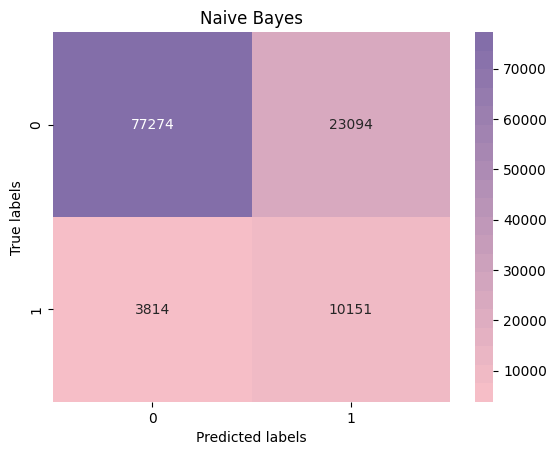

In [304]:
#NB prediction and metrics

nb_pred = nb.predict(X_test)
print("Accuracy score is:", accuracy_score(y_test,nb_pred))
print("Recall is:", recall_score(y_test,nb_pred))
print("Precision is:", precision_score(y_test,nb_pred))
print("F1 is:", f1_score(y_test,nb_pred))
plot_confusion_matrix(y_test,nb_pred)
title('Naive Bayes')
show()

In [305]:
print('Prior probability for the negative class is',)
print(exp(nb.class_log_prior_[0]))
print('Prior probability for the positive class is',)
print(exp(nb.class_log_prior_[1]))

Prior probability for the negative class is
0.8772565748043296
Prior probability for the positive class is
0.12274342519566961


In [306]:
feature_stats = pd.DataFrame({'Positive class':np.exp(nb.feature_log_prob_[1]),
                           'Negative class':np.exp(nb.feature_log_prob_[0])},
                           index=X.columns.values) # <-- feature names
feature_stats[:5]

,Positive class,Negative class
"Q(""Gender_0"")[False]",0.057422,0.050391
"Q(""Gender_0"")[True]",0.036829,0.044569
"Q(""Gender_1"")[T.True]",0.057422,0.050391
"Q(""Driving_License_0"")[T.True]",0.000081,0.000222
"Q(""Driving_License_1"")[T.True]",0.094171,0.094738


In [307]:
feature_stats['Positive/Negative Ratio'] = feature_stats['Positive class']\
                                         / feature_stats['Negative class']
feature_stats['Importance'] = \
    np.abs(np.log(feature_stats['Positive/Negative Ratio']))
feature_stats

,Positive class,Negative class,Positive/Negative Ratio,Importance
"Q(""Gender_0"")[False]",0.057422,0.050391,1.139531,0.130617
"Q(""Gender_0"")[True]",0.036829,0.044569,0.826338,0.190752
"Q(""Gender_1"")[T.True]",0.057422,0.050391,1.139531,0.130617
"Q(""Driving_License_0"")[T.True]",0.000081,0.000222,0.363097,1.013086
"Q(""Driving_License_1"")[T.True]",0.094171,0.094738,0.994010,0.006008
"Q(""Previously_Insured_0"")[T.True]",0.093929,0.045433,2.067407,0.726295
"Q(""Previously_Insured_1"")[T.True]",0.000322,0.049527,0.006509,5.034619
"Q(""Vehicle_Damage_0"")[T.True]",0.002003,0.053290,0.037590,3.281006
"Q(""Vehicle_Damage_1"")[T.True]",0.092248,0.041670,2.213786,0.794704
"Q(""Region_Central"")[T.True]",0.013611,0.018095,0.752203,0.284749


In [308]:
feature_stats=feature_stats.sort_values(by='Importance', ascending=False)[:5]

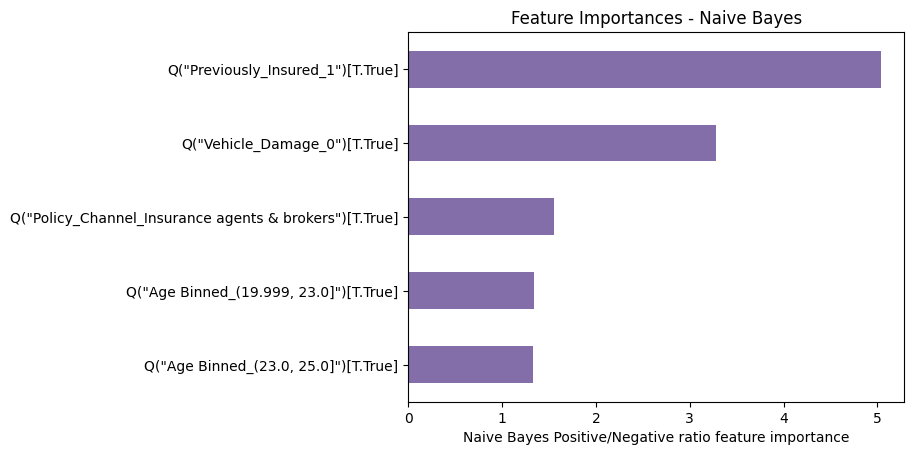

In [310]:
feature_stats['Importance'].nlargest(5)[::-1].plot(kind='barh', color='#836EA9')
title("Feature Importances - Naive Bayes")
xlabel("Naive Bayes Positive/Negative ratio feature importance")
show()